# Aprendizaje No Supervisado

Durante la primera fase del trabajo se evaluó el desempeño de distintos modelos sobre el dataset resumido a nivel de video con un total de 957 observaciones, en el cual cada registro representaba características agregadas del conjunto de frames pertenecientes a un mismo clip. Si bien este enfoque permitió obtener una visión general del comportamiento promedio de cada video, se identificaron limitaciones importantes para la detección precisa de anomalías.

Inicialmente, se realizaron pruebas usando el dataset a nivel de video, pero los resultados obtenidos mostraron un recall demasiado bajo, incluso tras ajustar los principales hiperparametros del modelo. Esto debido a que el dataset de videos contenía pocas observaciones y a que la agregación de los valores por clip diluía la presencia de comportamientos anómalos locales dentro de la información general.

Entonces se decidió migrar el análisis al nivel de frame individual, de este modo cada frame se considera una observación independiente, lo que permite preservar el detalle de cada uno de las escenas. Este cambio de enfoque aumenta significativamente la cantidad de datos disponibles (de solo tener menos de mil videos a más de 400 000 frames), dando al modelo una mayor base para aprender patrones normales y detectar outliers con más precisión.

Se usaran dos algoritmos muy usados para la detección de anomalías uno de ellos es Isolation Forest y el otro es DBSCAN seran evaluados para que el F1-Score este lo más alto posible. Siempre teniendo en cuenta que priorizaremos el recall sobre la precision.


## **Preprocesamiento de los datos**

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Trayendo la data
data = pd.read_csv("dataframe_frames.csv")
data.head(1)

/tmp/ipython-input-2734600309.py:7: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("dataframe_frames.csv")


,frame_number,frame_filename,left,top,right,bottom,confidence,class_id,width,height,...,has_motorcycle,has_bus,has_backpack,has_handbag,has_suitcase,has_knife,has_laptop,has_cell phone,video_detection_rate,video_avg_persons
0,17,frame_17.jpg,111.24295,0.0,128.81424,36.87331,0.465824,0.0,17.57129,36.87331,...,1,0,0,0,0,0,0,0,0.842932,3.146597


Se uso el dataset de frames y la distribución de clases en este dataset está muy desbalanceado y se probó si esto afectaba en algo a los resultados que podríamos a obtener. Tenemos 383325 frames normales y 58897 anormales. Esto debido a que el dataset usa más videos normales que anormales para trabajar a nivel de video y aparte que los videos anómalos no contienen tantos números de frames.

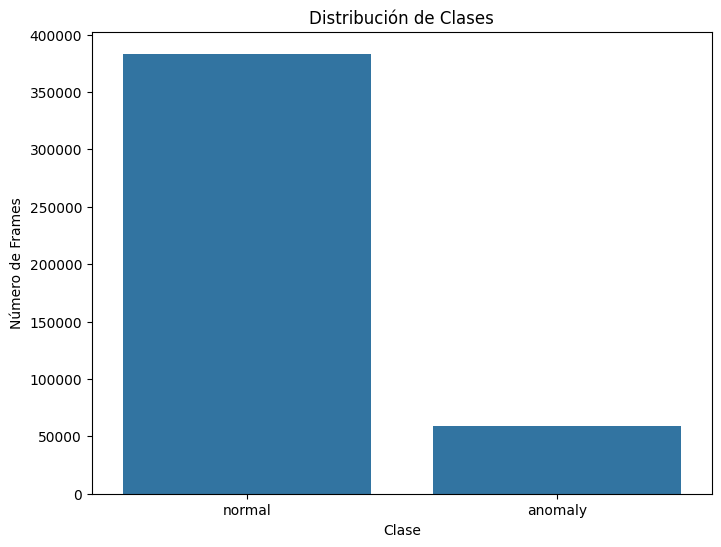

In [4]:
y = data['label']

class_counts = y.value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribución de Clases')
plt.xlabel('Clase')
plt.ylabel('Número de Frames')
plt.show()


Se procedió a seguir con el procesamiento de los datos, primero eliminamos las columnas que no aportan nada a la predicción que en este caso sería: “video_name”, “video_folder”, “split”, “frame_filename”. Variables que solo permiten identificar al frame si es que se esta buscando en el dataset. Luego eliminamos nuestra variable objetivo ya que no la vamos a usar para entrenar debido a que estamos usando aprendizaje no supervisado. Después escalamos los datos con StandarScaler para luego usar PCA con esos datos escalados para la reducción de la dimensionalidad, esto para reducir el número de variables que puedan mostrar la mejor información. De las 31 variables que teníamos PCA las redujo a solo 19 y con esto teníamos los datos procesados para el entrenamiento de los algoritmos no supervisados.

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

data_clean = data.drop(columns=['video_name', 'video_folder','split','frame_filename'], errors='ignore')

X = data_clean.drop(columns=['label'])
y = data_clean['label'].apply(lambda x: 1 if x == 'anomaly' else 0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95, random_state=123)
X_pca = pca.fit_transform(X_scaled)

print("Shape original:", X_scaled.shape)
print("Shape después de PCA:", X_pca.shape)


Shape original: (442222, 31)
Shape después de PCA: (442222, 19)


## **Modelo 1: Isolation Forest**

Se entreno con Isolation Forest tratando de maximizar el recall que es el propósito del caso de uso de videovigilancia.

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score, precision_score

iso = IsolationForest(
    n_estimators=500,
    contamination=0.1,
    random_state=123
)
iso.fit(X_pca)

y_pred = iso.predict(X_pca)
y_pred = [1 if p == -1 else 0 for p in y_pred]

recall = recall_score(y, y_pred)
print(f"Recall: {recall:.4f}")
precision = precision_score(y, y_pred)
print(f"Precision: {precision:.4f}")

Recall: 0.1691
Precision: 0.2252


Como se puede observar el recall de anomalías se pudo llegar a 17% con el hiperparametro “contamination” en un 10% eso quiere decir que le estamos diciendo que el 10% de los datos son anómalos aproximadante.
Al ver que el recall no era muy alto se tuvo que calibrar los hiperparametros, pero esta vez para la métrica F1 la cual es un balance entre recall y precision ya que por lo que se puede observar la precision también es muy baja lo que quiere decir que hay demasiadas alertas por el coste de poder predecir algunos anómalos. También se busco el mejor treshold para este mismo objetivo con la ayuda de los percentiles.


In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, classification_report
import numpy as np

iso = IsolationForest(
    n_estimators=500,
    contamination=0.25,
    max_samples=0.8,
    random_state=123
)

iso.fit(X_pca)
scores = iso.decision_function(X_pca)
y_true = y

best_f1 = 0
best_th = None
best_pred = None

for p in np.linspace(5, 95, 50):
    th = np.percentile(scores, p)
    y_pred = (scores < th).astype(int)
    f1 = f1_score(y_true, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_th = th
        best_pred = y_pred

print(f"Mejor F1: {best_f1:.4f} con threshold = {best_th:.4f}")
print(classification_report(y_true, best_pred))


Mejor F1: 0.3672 con threshold = 0.0097
              precision    recall  f1-score   support

           0       0.93      0.70      0.80    383325
           1       0.25      0.66      0.37     58897

    accuracy                           0.70    442222
   macro avg       0.59      0.68      0.58    442222
weighted avg       0.84      0.70      0.74    442222




El mejor treshold encontrado para maximizar el F1 fue 0.0097 eso quiere decir que el frame con menor score que 0.0097 será considerado anomalía (1), el resto será normal (0). Se saco la matriz de confusión para este resultado con este mejor treshold y estos fueron los resultados.


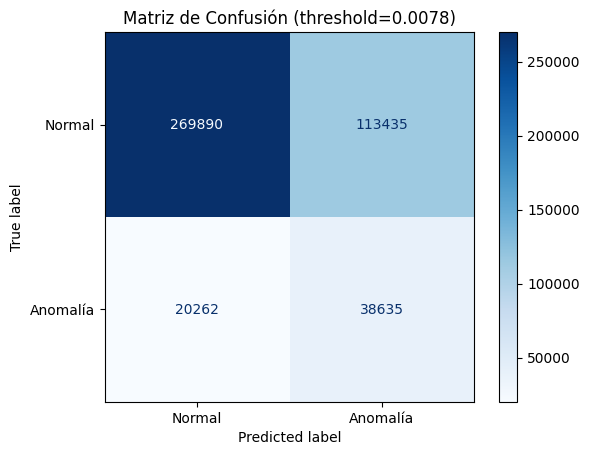

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Matriz de confusión
cm = confusion_matrix(y_true, best_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomalía"])
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Matriz de Confusión (threshold={best_th:.4f})")
plt.show()



Se puede observar que hay demasiadas falsas alarmas y también muchos frames anómalos son detectados como normales. Esto en un sistema de videovigilancia no sería un modelo óptimo ya que la confiabilidad del sistema se vería comprometida. Se sabe que en estos casos de uso se debe priorizar una alta sensibilidad (recall) para asegurar que la mayoría de comportamientos anómalos sean identificados, incluso si eso implica aceptar un mayor número de falsos positivos. Aún así el resultado es muy alto por lo que se probó el dataset de otra manera.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, f1_score

idx_norm = np.where(y == 0)[0]
idx_anom = np.where(y == 1)[0]

ratios = [1, 2, 3]

for r in ratios:
    n_anom = len(idx_anom)
    n_norm = min(len(idx_norm), r * n_anom)

    np.random.seed(123)
    sampled_norm_idx = np.random.choice(idx_norm, n_norm, replace=False)
    subset_idx = np.concatenate([sampled_norm_idx, idx_anom])

    X_sub = X_pca[subset_idx]
    y_sub = y.iloc[subset_idx]

    contamination = len(idx_anom) / len(subset_idx)

    iso = IsolationForest(
        n_estimators=500,
        contamination=contamination,
        random_state=123
    )
    iso.fit(X_sub)

    scores = iso.decision_function(X_sub)

    best_f1 = 0
    best_th = None
    best_pred = None

    for p in np.linspace(5, 95, 50):
        th = np.percentile(scores, p)
        y_pred = (scores < th).astype(int)
        f1 = f1_score(y_sub, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th
            best_pred = y_pred

    print(f"\n Ratio normales:anom = {r}:1  -> Best F1: {best_f1:.4f} (threshold={best_th:.4f})")
    print(f"Entrenando con {len(X_sub)} muestras ({len(sampled_norm_idx)} normales + {len(idx_anom)} anomalías)")
    print(classification_report(y_sub, best_pred))




 Ratio normales:anom = 1:1  -> Best F1: 0.6870 (threshold=0.0274)
Entrenando con 117794 muestras (58897 normales + 58897 anomalías)
              precision    recall  f1-score   support

           0       0.73      0.29      0.41     58897
           1       0.56      0.90      0.69     58897

    accuracy                           0.59    117794
   macro avg       0.65      0.59      0.55    117794
weighted avg       0.65      0.59      0.55    117794


 Ratio normales:anom = 2:1  -> Best F1: 0.5710 (threshold=0.0338)
Entrenando con 176691 muestras (117794 normales + 58897 anomalías)
              precision    recall  f1-score   support

           0       0.85      0.46      0.60    117794
           1       0.43      0.83      0.57     58897

    accuracy                           0.58    176691
   macro avg       0.64      0.65      0.58    176691
weighted avg       0.71      0.58      0.59    176691


 Ratio normales:anom = 3:1  -> Best F1: 0.5006 (threshold=0.0351)
Entrenando c

## **Conclusiones de Isolation Forest**

A continuación, se muestran los resultados obtenidos al aplicar la función antes mostrada para diferentes proporciones entre frames.

Como se observa, cuando el dataset se balancea completamente (ratio 1:1), el modelo alcanza su mayor recall (90%), lo cual indica que logra detectar la mayoría de los frames anómalos. Sin embargo, esto ocurre a costa de un descenso de precision, generando una cantidad de falsas alarmas como era de esperarse.

Luego al incrementar la proporción de frames normales (ratios 2:1 y 3:1), la precisión mejora gradualmente, pero el recall disminuye. Esto confirma que el balance de clases influye directamente en el desempeño del Isolation Forest, afectando la sensibilidad del modelo frente a eventos anómalos.

Para esta parte del trabajo se implementó un enfoque no supervisado para la detección de anomalías en video utilizando el algoritmo Isolation Forest trabajado con los features que devuelve YOLO, tomando como referencia el estudio “Anomaly Detection in Video Surveillance Using YOLOv8”. Si bien en dicho reporte se consigue un desempeño sobresaliente sobre un conjunto de clips preprocesados y equilibrados, en este caso el dataset empleado presentó un fuerte desbalanceo de clases, con una proporción aproximada de 6.5:1 entre frames normales y anómalos.
Con estas pruebas se pudo demostrar que, aunque Isolation Forest mostró cierto potencial bajo condiciones balanceadas, su rendimiento en escenarios reales (donde predominan los eventos normales) resulta limitado. Es por ello que en el paper de referencia recomienda estrategias complementarias como reajuste de umbrales, muestreo balanceado o el uso de modelo híbridos supervisados.


## **Modelo 2: DBSCAN**

Se empleará el algoritmo DBSCAN con el propósito de detectar patrones inusuales en las características obtenidas por YOLO. A diferencia de Isolation Forest, DBSCAN permite identificar grupos de frames similares según su densidad en el espacio de características, esto sin requerir especificar previamente el número de grupos. Este enfoque se centra en utilizar DBSCAN como una herramienta no supervisada para separar los frames que presentan comportamientos normales de los posibles frames anómalos, que se ubican en zonas menos densas y son tratados como ruido por el modelo.

Al aplicar DBSCAN en este contexto es evaluar si este método logra una mejor identificación de frames anómalos en comparación con modelos previos como Isolation Forest, especialmente considerando el fuerte desbalanceo de clases presente en el dataset y la naturaleza no lineal de los datos extraídos mediante PCA.

Se intento primero con un conjunto de parámetros iniciales (eps = 0.5 y min_samples = 10) como punto de partida para observar el comportamiento del algoritmo sobre el dataset de frames. Estos valores permiten evaluar si el método logra identificar correctamente grupos densos de frames normales y distinguir aquellos considerados anómalos. A partir de estos resultados iniciales, se puede ajustar gradualmente los parámetros para mejorar la detección de anomalías.


In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, f1_score
import numpy as np

dbscan = DBSCAN(eps=0.5, min_samples=10, n_jobs=-1)
dbscan.fit(X_pca)
y_pred = (dbscan.labels_ == -1).astype(int)

y_true = y.values

print(classification_report(y_true, y_pred))
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")

print(f"Clusters encontrados: {len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)}")
print(f"Anomalías detectadas: {sum(y_pred)} de {len(y_pred)} muestras")

              precision    recall  f1-score   support

           0       0.96      0.33      0.49    383325
           1       0.17      0.92      0.29     58897

    accuracy                           0.40    442222
   macro avg       0.57      0.62      0.39    442222
weighted avg       0.86      0.40      0.46    442222

F1-score: 0.2906
Clusters encontrados: 1496
Anomalías detectadas: 312569 de 442222 muestras


Como se puede observar con estos primeros parámetros iniciales, se observa un bajo desempeño general del modelo, con un F1-score de 0.29. Por lo que se puede ver el algoritmo logra detectar una gran cantidad de anomalías (más de 300 000), pero la mayoría corresponden a falsas alarmas, por lo que se ve con una alta precision para la clase normal pero un recall muy alto en la clase anómala.

In [ ]:
for eps in [0.7, 1.0, 1.3]:
    for min_s in [5, 10, 20]:
        db = DBSCAN(eps=eps, min_samples=min_s, n_jobs=-1).fit(X_pca)
        y_pred = (db.labels_ == -1).astype(int)
        print(f"eps={eps}, min_samples={min_s} -> F1={f1_score(y, y_pred):.4f}")


eps=0.7, min_samples=5 -> F1=0.3936
eps=0.7, min_samples=10 -> F1=0.3888
eps=0.7, min_samples=20 -> F1=0.3569
eps=1.0, min_samples=5 -> F1=0.3118
eps=1.0, min_samples=10 -> F1=0.3774
eps=1.0, min_samples=20 -> F1=0.4294
eps=1.3, min_samples=5 -> F1=0.1815
eps=1.3, min_samples=10 -> F1=0.2405
eps=1.3, min_samples=20 -> F1=0.3039


Se realizó una calibración de hiperparametros del algoritmo DBSCAN, variando los valores de eps y min_samples para analizar cómo afectan el desempeño del modelo en la detección de frames anómalos. En los resultados se puede ver que el rendimiento varía significativamente según la configuración: valores de eps muy bajos o muy altos tiende a empeorar el desempeño, caso contrario con configuraciones intermedias logran un mejor equilibrio.

El mejor resultado se obtuvo con eps = 1.0 y min_samples = 20, alcanzando un F1-score de 0,43, lo que indica una mejora para distinguir entre frames normales o anómalos.


In [6]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import classification_report, f1_score
import numpy as np

dbscan = DBSCAN(eps=1.0, min_samples=35, n_jobs=-1)
dbscan.fit(X_pca)
y_pred = (dbscan.labels_ == -1).astype(int)

y_true = y.values

print(classification_report(y_true, y_pred))
print(f"F1-score: {f1_score(y_true, y_pred):.4f}")

print(f"Clusters encontrados: {len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)}")
print(f"Anomalías detectadas: {sum(y_pred)} de {len(y_pred)} muestras")


              precision    recall  f1-score   support

           0       0.95      0.76      0.85    383325
           1       0.32      0.72      0.44     58897

    accuracy                           0.76    442222
   macro avg       0.63      0.74      0.64    442222
weighted avg       0.86      0.76      0.79    442222

F1-score: 0.4403
Clusters encontrados: 173
Anomalías detectadas: 132549 de 442222 muestras


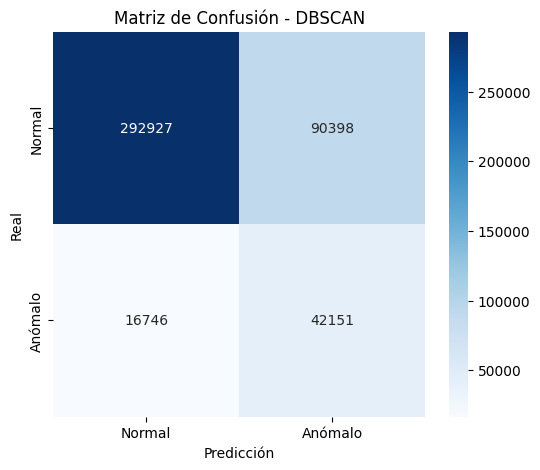

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal', 'Anómalo'],
            yticklabels=['Normal', 'Anómalo'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión - DBSCAN')
plt.show()


## **Conclusiones de DBSCAN**
A partir de los resultados anteriores se empezó fijando el valor de eps = 1.0 y variando el parámetro min_samples con el objetivo de mejorar el rendimiento del modelo. Este parámetro controla cuántos puntos se necesitan para formar un clúster, por lo que ajustar su valor permite modificar la sensibilidad del algoritmo frente a las regiones densas o dispersas de los datos.
El mejor resultado se obtuvo con min_samples = 35, alcanzando un F1-score de 0,44 y un recall de 0,72, luego de haber probado desde el valor 20 hasta el 50 pero por la falta de memoria su tuvo que realizar manualmente.

Esto sugiere que el algoritmo DBSCAN es capaz de adaptarse de manera más efectiva cuando se ajusta cuidadosamente la densidad mínima requerida, aunque aún enfrenta limitaciones debido al fuerte desbalance y la complejidad intrínseca del dataset de videovigilancia.


## **Conclusiones del Algoritmo No supervisado**

Luego de haber aplicado dos de los mejores algoritmos no supervisados centrados en la detección de anomalías, Isolation Forest y DBSCAN. Ambos permitieron evaluar el comportamiento del dataset sin necesidad de etiquetas en el entrenamiento, lo que es útil en escenarios donde no se dispone de datos previamente clasificados.

Ahora hablando de cada uno de los modelos, Isolation Forest mostró un desempeño moderado, logrando identificar una cantidad razonable de frames anómalos, aunque con un recall bajo, lo que indica que muchos eventos pasaron desapercibidos. Lo que sugiere que el algoritmo no logró aislar correctamente los puntos fuera del comportamiento normal y se pudo comprobar que fue más por el desbalance de clases, ya que al equilibrar el dataset se pudo comprobar una mejora considerable en la detección de anomalías.

En el caso de DBSCAN se pudo obtener un mejor F1-score (0,44) y un recall mucho más alto siendo capaz de identificar una mayor proporción de anomalías reales, aunque con el costo de contar con un número de falsas alarmas. Aún así, este comportamiento puede considerarse aceptable en un sistema de vigilancia, donde es preferible recibir algunas alertas de más antes que dejar pasar una anomalía crítica sin detectar.

Por ende, el mejor modelo que se pudo adaptar fue DBSCAN, pero si el dataset creado mediante YOLO hubiera habido un balance de clases decente (2:1) los dos modelos hubieran sido decentes para este caso de uso.
